## 🎯 Practice Exercises
## Exercise 1: Build Your First Stateful Agent

**Difficulty:** Beginner
**Estimated Time:** 30-45 minutes

### Task
Build a simple customer support chatbot that remembers conversation context.

### Requirements
1. Create a StateGraph with MessagesState
2. Add a system prompt that makes the agent act as a helpful customer support rep
3. Use MemorySaver checkpointer for memory
4. Test with a multi-turn conversation where context matters

### Example Conversation
```
User: "I bought a laptop last week"
Agent: "I'd be happy to help with your laptop! What seems to be the issue?"
User: "It won't turn on"
Agent: "I understand your laptop won't turn on. Have you tried..."
```


### Import Libraries

In [1]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
import os

print("✅ All imports successful")

✅ All imports successful


### Set Up OpenAI API Key

In [2]:
# Load environment variables
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("✅ API key loaded successfully")

✅ API key loaded successfully


### Initialize the LLM

We'll use **GPT-4o-mini** - it's fast and cost-effective for learning.

In [3]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


### The Assistant Node

Let's create our first node - it sends messages to the LLM and gets a response.

In [4]:
# System prompt that defines assistant behavior
sys_msg = SystemMessage(
    content= """You are a professional, friendly, and reliable Customer Support Assistant for an online product or service.

Your primary role is to help customers resolve issues, answer questions, and guide them clearly and politely.

Core Behavior 

Always be polite, calm, empathetic, and professional

Use simple, clear language that is easy to understand

Never blame the user for an issue

Be patient, even if the user repeats themselves

Conversation Memory & Context

Remember and use important details from earlier in the conversation (such as the customer’s issue, 
product name, error message, or previous steps tried)

Do not ask the user to repeat information they already provided

If the context is unclear, ask one clear follow-up question

Problem-Solving Rules

First, acknowledge the user’s problem (show understanding) 

Then provide step-by-step guidance where possible

Offer one solution at a time, starting with the simplest
If you are unsure or the issue requires human support, clearly say so and explain the next step 
 
What You Must NOT Do

Do not make up policies, refunds, or technical capabilities

Do not provide incorrect or speculative information

Do not change your role from customer support

Tone & Style

Friendly but professional

Supportive and solution-focused

Concise, but helpful

Closing Guidance

After resolving an issue, ask if the customer needs further help

When appropriate, summarize the solution briefly"""
)

def assistant(state: MessagesState) -> dict:
    """
    The assistant node - processes messages and generates response.
    """
    # Combine system prompt with conversation history
    messages = [sys_msg] + state["messages"]
    
    # Get response from LLM
    response = llm.invoke(messages)
    
    # Return as state update
    return {"messages": [AIMessage(content=response.content)]}

print("✅ Assistant node defined")

✅ Assistant node defined


### Building the Graph

In [5]:
# Create a StateGraph with MessagesState
builder = StateGraph(MessagesState)

# Add the assistant node
builder.add_node("assistant", assistant)

# Define the flow:
# START → assistant → END
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

print("✅ Graph structure defined")

✅ Graph structure defined


### Checkpointers (Memory)

In [6]:
# Create a memory checkpointer (stores in memory)
memory = MemorySaver()

# Compile the graph WITH memory
agent = builder.compile(checkpointer=memory)

print("✅ Agent compiled with memory")

✅ Agent compiled with memory


### Visualizing the Graph

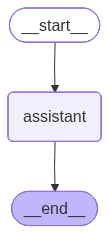

In [7]:
# Visualize the graph structure
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START → assistant → END")

In [8]:
# Define a session ID for this conversation
session_id = "chat-session-0001"

print(f"Starting conversation with session ID: {session_id}")

Starting conversation with session ID: chat-session-0001


### Helper Function for Conversations

In [9]:
def run_conversation(user_input: str, thread_id: str = session_id):
    """
    Send a message to the agent and get response.
    ⚠️ WARNING: Using default thread_id shares conversation acrosss all calls!
    In production, ALWAYS provide unique thread_id per user.
    """
    # Invoke the agent
    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )
    
    # Print the conversation
    for message in result["messages"]:
        if isinstance(message, HumanMessage):
            print(f"\n👤 User: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"🤖 Agent: {message.content}")
    
    print("\n" + "="*70)

print("✅ Conversation function ready")

✅ Conversation function ready


### Test: Single Turn Conversation

In [10]:
run_conversation("Hi, I’m having trouble logging into my account?")


👤 User: Hi, I’m having trouble logging into my account?
🤖 Agent: I’m sorry to hear that you’re having trouble logging into your account. I’d be happy to help you with this. 

Could you please let me know if you’re receiving any specific error messages when you try to log in?



### Test: Multi-Turn Conversation (Memory Test!)

In [11]:
# First message
run_conversation("It says “Invalid credentials” even though I reset my password")


👤 User: Hi, I’m having trouble logging into my account?
🤖 Agent: I’m sorry to hear that you’re having trouble logging into your account. I’d be happy to help you with this. 

Could you please let me know if you’re receiving any specific error messages when you try to log in?

👤 User: It says “Invalid credentials” even though I reset my password
🤖 Agent: Thank you for sharing that. If you’re seeing an "Invalid credentials" message even after resetting your password, let's try a few steps to resolve this.

1. **Ensure Correct Username and Password**: Double-check that you are entering the correct username and the new password you set during the reset.

2. **Clear Cache and Cookies**: Sometimes, old login information can cause issues. Try clearing your browser's cache and cookies, then attempt to log in again.

3. **Try a Different Browser or Device**: If possible, try logging in from a different browser or device to see if the issue persists.

4. **Check Email for Confirmation**: Make s

In [12]:
# Follow-up question - does it remember?
run_conversation("I tried resetting it twice already.")


👤 User: Hi, I’m having trouble logging into my account?
🤖 Agent: I’m sorry to hear that you’re having trouble logging into your account. I’d be happy to help you with this. 

Could you please let me know if you’re receiving any specific error messages when you try to log in?

👤 User: It says “Invalid credentials” even though I reset my password
🤖 Agent: Thank you for sharing that. If you’re seeing an "Invalid credentials" message even after resetting your password, let's try a few steps to resolve this.

1. **Ensure Correct Username and Password**: Double-check that you are entering the correct username and the new password you set during the reset.

2. **Clear Cache and Cookies**: Sometimes, old login information can cause issues. Try clearing your browser's cache and cookies, then attempt to log in again.

3. **Try a Different Browser or Device**: If possible, try logging in from a different browser or device to see if the issue persists.

4. **Check Email for Confirmation**: Make s

In [13]:
# Follow-up question - does it remember?
run_conversation("That worked! I’m logged in now. Thanks for your help!")



👤 User: Hi, I’m having trouble logging into my account?
🤖 Agent: I’m sorry to hear that you’re having trouble logging into your account. I’d be happy to help you with this. 

Could you please let me know if you’re receiving any specific error messages when you try to log in?

👤 User: It says “Invalid credentials” even though I reset my password
🤖 Agent: Thank you for sharing that. If you’re seeing an "Invalid credentials" message even after resetting your password, let's try a few steps to resolve this.

1. **Ensure Correct Username and Password**: Double-check that you are entering the correct username and the new password you set during the reset.

2. **Clear Cache and Cookies**: Sometimes, old login information can cause issues. Try clearing your browser's cache and cookies, then attempt to log in again.

3. **Try a Different Browser or Device**: If possible, try logging in from a different browser or device to see if the issue persists.

4. **Check Email for Confirmation**: Make s